In [1]:
import pandas as pd
from scipy.stats import entropy
import queue
import numpy as np
import gensim
from collections import defaultdict
from functools import reduce, partial
from scipy.spatial.distance import euclidean
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from nltk import tokenize
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import euclidean_distances
from sklearn import manifold
from sklearn.cluster import DBSCAN

from source.Topic.Utils import *
from source.Topic.Model import *
import re

from sentence_transformers import SentenceTransformer

Using TensorFlow backend.


In [2]:
meta = pd.read_csv("kaffee_reviews.csv")
meta.drop(columns=["index"], inplace=True)

In [3]:
sentences = []
for i in meta.review:
    sentences.append(nltk.sent_tokenize(i, language='german'))
sentences = np.concatenate(sentences).tolist()

In [4]:
method = "BERT_AE" # "LDA_BERT"
samp_size = len(meta.review)
ntopic = 10

rws = meta.review
#rws = pd.Series(sentences)
sentences, token_lists, idx_in = preprocess(sentences, samp_size=len(sentences))

Preprocessing raw texts ...
Preprocessing raw texts. Done!


In [5]:
len(sentences)

1191

In [6]:
model = SentenceTransformer("distiluse-base-multilingual-cased")

In [7]:
words, words_counts = np.unique(np.concatenate(token_lists), return_counts=True)
embeddings = model.encode(words)


In [8]:
def synonyme(unique_words_count, embeddings, eps=0.3, min_samples=2):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(embeddings)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    #[np.where(labels == i)[0] for i in range(n_clusters_)]
    count = 0
    syn = {}
    syn_i = {}
    for word_idx in np.where(labels == -1)[0]:
        syn[word_idx] = count
        syn_i[count] = word_idx
        count += 1
    for cluster in [np.where(labels == i)[0] for i in range(n_clusters_)]:
        # print([words[j] for j in cluster])
        for word_idx in cluster:
            syn[word_idx] = count
        syn_i[count] = cluster[unique_words_count[cluster].argmax()]
        count += 1
    return syn, syn_i, count

syn, syn_i, n_syn = synonyme(words_counts, embeddings)

Estimated number of clusters: 45
Estimated number of noise points: 762


In [9]:
mat = np.zeros((n_syn, n_syn))
for k, token_list in enumerate(token_lists):
    syn_tokens = np.unique([syn[np.where(words==i)[0][0]] for i in token_list])
    token_combinations = np.array(np.meshgrid(syn_tokens, syn_tokens)).T.reshape(-1, 2)
    for i, j in token_combinations:
        if i == j:
            mat[i][j] += 1 # len(syn_tokens) - 1
        else:
            mat[i][j] += 1

mat_p = np.zeros((n_syn, n_syn))
for i in range(n_syn):
    if mat[i][i] != 0:
        mat_p[i] = mat[i] / mat[i][i]
        # mat_p[i][i] = 0

In [10]:
# Kaffee = 239, syn[Kaffee] = 778
# Geschmack = 178, syn[Geschmack] = 775
# argmax 775
# q = syn[np.where(words == "Bewertung")[0][0]]
q = 778
[(words[syn_i[i]], np.round(mat_p[q][i] * 100, decimals=2)) for i in np.argsort(mat_p[q])[::-1]][:10]
# [np.round(sum(mat_p[i]), decimals=3) for i in range(mat_p.shape[0])]

[('Kaffee', 100.0),
 ('Geschmack', 10.32),
 ('Leck', 5.16),
 ('Aroma', 4.73),
 ('Bio', 3.66),
 ('Sorte', 3.44),
 ('Bohne', 3.44),
 ('Jahr', 3.23),
 ('gut', 2.58),
 ('Qualität', 2.58)]

In [11]:
np.argsort([sum(mat[i]) for i in range(n_syn)])[::-1][:10]

array([778, 774,  67, 763, 296,  78, 387, 456, 396, 407], dtype=int64)

In [12]:
p = 775
threshold = 10
[(words[syn_i[i]], np.round(mat_p[:, p][i] * 100, decimals=2), mat[:,p][i]) for i in np.argsort(mat_p[:, p])[::-1] if mat[:, p][i] > threshold][:10]
#mat_p[:, 775]

[]

In [13]:
bar = np.argsort([sum(mat[i]) for i in range(n_syn)])[::-1][:10]
for k in bar:
    foo = [(words[syn_i[i]], np.round(mat_p[k][i] * 100, decimals=2)) for i in np.argsort(mat_p[k])[::-1]][:10]
    print(foo)

[('Kaffee', 100.0), ('Geschmack', 10.32), ('Leck', 5.16), ('Aroma', 4.73), ('Bio', 3.66), ('Sorte', 3.44), ('Bohne', 3.44), ('Jahr', 3.23), ('gut', 2.58), ('Qualität', 2.58)]
[('Geschmack', 100.0), ('Kaffee', 36.09), ('Aroma', 9.77), ('Qualität', 5.26), ('Bohne', 4.51), ('Bio', 3.76), ('kaffeeautomat', 3.76), ('gut', 3.76), ('Sorte', 3.76), ('Duft', 3.01)]
[('Bio', 100.0), ('Kaffee', 26.56), ('Geschmack', 7.81), ('gut', 6.25), ('Fairtrade', 6.25), ('Qualität', 6.25), ('Produkt', 4.69), ('fairtrade', 4.69), ('preis', 3.12), ('Sorte', 3.12)]
[('Aroma', 100.0), ('Kaffee', 34.92), ('Geschmack', 20.63), ('Bohne', 4.76), ('Produkt', 4.76), ('Gefühl', 3.17), ('Röstung', 3.17), ('Bio', 3.17), ('bisschen', 3.17), ('bohn', 3.17)]
[('Leck', 100.0), ('Kaffee', 43.64), ('Geschmack', 7.27), ('Latte', 5.45), ('gewiß', 5.45), ('Bohne', 5.45), ('Firma', 3.64), ('Versand', 3.64), ('Original', 3.64), ('Milch', 3.64)]
[('Bohne', 100.0), ('Kaffee', 41.03), ('Geschmack', 15.38), ('kaffeeautomat', 10.26), ('

In [12]:
mat[775][778]

80.0

In [14]:
class ConditionalProbability:
    def __init__(self, sentences, token_lists, syn, words):
        self.sentences = sentences
        self.token_lists = token_lists
        self.synonym = syn
        self.words = words
        self.words_index = dict(zip(self.words, range(len(self.words))))
        self.word_counts = words_counts
        self.syn_token_list = self.syn_token_list()
        self.token_sentence_map = self.token_sentence_map()

    def syn_token_list(self):
        '''
        transforms the tokens in a token_list to the corresponding synonyms
        :return:
        '''
        syn_token_list = []
        for token_list in self.token_lists:
            syn_tokens = np.unique([self.synonym[self.words_index[word]] for word in token_list]).tolist()
            syn_token_list.append(syn_tokens)
        return syn_token_list

    def token_sentence_map(self):
        '''
        maps sentences to tokens, i.e. for each token we get a list of sentences which contain that token
        :return:
        '''
        syn_token_to_sentence = defaultdict(list)
        for i, syn_tokens in enumerate(self.syn_token_list):
            for token in syn_tokens:
                syn_token_to_sentence[token].append(i)
        return syn_token_to_sentence

    def sentences_from_tokens(self, tokens, literal=False):
        '''
        returns a list of sentences which contain all tokens specified in tokens
        :param tokens:
        :param literal:
        :return:
        '''
        if literal:
            tokens = [self.synonym[self.words_index[token]] for token in tokens]
        return reduce(partial(np.intersect1d, assume_unique=True), [self.token_sentence_map[i] for i in tokens])

    def cond_prob(self, event_token, condition_tokens, literal=False):
        '''
        returns the conditional probability of a sentence to contain event_token if that sentence
        also contains all tokens specified in condition_tokens
        :param event_token:
        :param condition_tokens:
        :param literal:
        :return:
        '''
        if literal:
            event_token = self.synonym[self.words_index[event_token]]
        sen_with_token = self.sentences_from_tokens(condition_tokens, literal)
        count = len(sen_with_token)
        if count == 0:
            return 0
        sen_with_token = np.intersect1d(sen_with_token, self.token_sentence_map[event_token], assume_unique=True)
        return len(sen_with_token) / count

    def prob(self, event_token, literal=False):
        if literal:
            event_token = self.synonym[self.words_index[event_token]]
        return len(self.token_sentence_map[event_token]) / len(self.syn_token_list)

    def cond_prob_all_tokens(self, condition_tokens, return_probabilities=False, return_absolut=False, literal=False):
        if literal:
            condition_tokens = [self.synonym[self.words_index[token]] for token in condition_tokens]
        sen_with_token = self.sentences_from_tokens(condition_tokens)
        if len(sen_with_token) == 0:
            return np.zeros(n_syn).tolist()
        cond_probs = np.zeros(n_syn)
        cond_abs = np.zeros(n_syn)
        for i in range(n_syn):
            if i not in condition_tokens:
                all_events_count = len(np.intersect1d(sen_with_token, self.token_sentence_map[i], assume_unique=True))
                cond_probs[i] =  all_events_count / len(sen_with_token)
                cond_abs[i] = all_events_count
            else:
                cond_probs[i] = -1
        mask = [True, return_probabilities, return_absolut]
        result = np.array([np.argsort(cond_probs)[::-1], None, None])
        if return_probabilities:
            result[1] = np.sort(cond_probs)[::-1]
        if return_absolut:
            result[2] = cond_abs[result[0]]
        return result[mask]

cp = ConditionalProbability(sentences, token_lists, syn, words)

In [15]:
class Node:
    def __init__(self, value, parent=None):
        self.value = value
        self.parent = parent
        self.children = []

    def add_child(self, value):
        node = Node(value, self)
        self.children.append(node)
        return self

    def is_root(self):
        return self.parent is None

    def is_leaf(self):
        return len(self.children) == 0

    def __str__(self):
        return "%d" % self.value

    def __repr__(self):
        return str(self)

    def name(self):
        return str(self)

    def cum_name(self):
        node = self.parent
        cum_name = [self.value]
        while node is not None:
            cum_name.insert(0, node.value)
            node = node.parent
        return cum_name

    def get_leaves(self):
        if self.is_leaf():
            return [self]
        leaves = []
        for child in self.children:
            leaves += child.get_leaves()
        return leaves

    def get_newick(self):
        if self.is_leaf():
            return self.name()
        name_children = ",".join([child.get_newick() for child in self.children])
        return "(%s)%s" % (name_children, self.name())

    def get_newick_alt(self, func):
        if self.is_leaf():
            return func(self.value)
        name_children = ",".join([child.get_newick_alt(func) for child in self.children])
        return "(%s)%s" % (name_children, func(self.value))

root = Node(778)
threshold = 0.03
threshold2 = 2
threshold_rate = 0.00

In [18]:
def bar(root, threshold, threshold2):
    new_child = False
    leaves = root.get_leaves()
    for leaf in leaves:
        a, b, c = cp.cond_prob_all_tokens(leaf.cum_name(), return_probabilities=True, return_absolut=True)
        children = a[np.intersect1d(np.where(b > threshold)[0], np.where(c > threshold2)[0], assume_unique=True)]
        print(children)
        for child in children:
            leaf.add_child(child)
            new_child = True
    return new_child

bar(root, threshold, threshold2)
threshold += threshold_rate

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [100]:
root.children[0].children[1]

[]

In [19]:
from ete3 import TreeStyle, Tree, TextFace, add_face_to_node
t = Tree(root.get_newick_alt(lambda x: words[syn_i[x]]) + ";" , format=1)

ts = TreeStyle()
ts.show_leaf_name = False
ts.show_scale = False
ts.show_branch_length = False
def my_layout(node):
    F = TextFace(node.name, tight_text=True)
    add_face_to_node(F, node, column=0, position="branch-right")
ts.layout_fn = my_layout
t.show(tree_style=ts)

(array([ 74.,   0., 114.,   0., 105.,   0.,  55.,   0.,  30.,   0.,   0.,
          9.,   0.,   9.,   0.,   5.,   0.,   2.,   0.,   2.]),
 array([ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
         5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65,
         9.1 ,  9.55, 10.  ]),
 <a list of 20 Patch objects>)

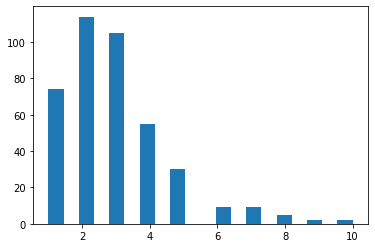

In [36]:
plt.hist([len(tokens) for tokens in token_lists if "Kaffee" in tokens], bins=20)
